In [1]:
from gnucash_business_reports.builder import GnuCash_Data_Analysis
import numpy as np
from great_tables import GT, md
import polars as pl
import polars.selectors as cs
import pandas as pd
from pathlib import Path


gda = GnuCash_Data_Analysis()
gda.year = 2024

In [2]:
gda.sanity_checker()

2024-10-24 08:19:58,731 | INFO: guid              object
name              object
account_type      object
commodity_guid    object
commodity_scu      int64
non_std_scu        int64
parent_guid       object
code              object
description       object
hidden             int64
placeholder        int64
account_notes     object
dtype: object
2024-10-24 08:19:58,748 | INFO:                                                                              name  \
guid                                                                                
15fdb1f76e137e8aaa180dd175c1e56e                                     Root Account   
8dbe6b242057e03b3bd16f670d3310b4                                           Assets   
ad766ab9936c920bf935b88a8aee7b06                                   Current Assets   
1f613a6022db4c68440e38a73b8357ba                                  Prepaid Expense   
0cbe54754deab37469301069e9639e50                                    Hedge Account   
...                        

True

In [3]:
gda.get_balance_sheet()

/home/justin/gnucash_business_reports/gnucash_business_reports/builder.py:480: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_tx = pd.concat([all_tx, tx])
/home/justin/gnucash_business_reports/gnucash_business_reports/builder.py:480: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_tx = pd.concat([all_tx, tx])


,amt,qty
balance_sheet_category,,
Assets,1631871.72,5483498.47
Cash,142866.52,142866.52
Liabilities,-441594.25,-441594.25
Grain,132565.27,56967.37


In [4]:
# print(gda.get_executive_summary(include_depreciation=False))
# df = gda.get_farm_cash_transactions(include_depreciation=True)
# print(df.dtypes)
# print(df.sort_values("account_code").groupby(["account_code", "account_name"]).sum())
# print(gda.get_summary_by_account())

# flex = gda.flexible_lease_calculator()

# flex.to_csv("export/flex.csv")
# print(gda.get_corporation_value())
# print(gda.get_personal_business_expenses())

# gda.get_production().to_csv(f"export/{gda.year}-production.csv")

In [5]:
gda.get_balance_sheet_details()

/home/justin/gnucash_business_reports/gnucash_business_reports/builder.py:480: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_tx = pd.concat([all_tx, tx])
/home/justin/gnucash_business_reports/gnucash_business_reports/builder.py:480: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_tx = pd.concat([all_tx, tx])


,,account_type,account_desc,parent_guid,commodity_guid,account_name,account_code,src_guid,src_code,src_type,src_name,...,split_guid,amt,qty,reconcile_date,reconcile_state,memo,finpack_account,parent_accounts,quantity,balance_sheet_category
tx_guid,account_guid,,,,,,,,,,,,,,,,,,,,,
a4f285fc40eb2bd54c4e2dc7687f4e56,25a9a53808cd87732e7ef1eeb4a551b2,BANK,Corporate Checking Account,ad766ab9936c920bf935b88a8aee7b06,a5cb4782e9d344e693e7c99cb35eb687,Corporation Account,100,1f613a6022db4c68440e38a73b8357ba,146,ASSET,Prepaid Expense,...,b4d5b87d8dcbe076baa1965adbb4abcd,46134.92,46134.92,2017-05-11 08:59:59,y,,Current Assets,Current Assets>Assets>Root Account,0.00,Assets
1c71a60d5f3f92bd73c5ad4602e85653,d663497c7692d8c6cd644e035d2c1d72,EXPENSE,Fertilizer,298fcecb14ee7edda867151d0a0fbe7d,a5cb4782e9d344e693e7c99cb35eb687,Fertilizer,402,1f613a6022db4c68440e38a73b8357ba,146,ASSET,Prepaid Expense,...,6a64461f9a17dba3ca5641cb9b84677d,-46134.92,-46134.92,1970-01-01 00:00:00,n,,Fertilizer,Expenses>Root Account,0.00,Assets
9d21c366e1ef09ee970e7fc3c1486d70,25a9a53808cd87732e7ef1eeb4a551b2,BANK,Corporate Checking Account,ad766ab9936c920bf935b88a8aee7b06,a5cb4782e9d344e693e7c99cb35eb687,Corporation Account,100,1f613a6022db4c68440e38a73b8357ba,146,ASSET,Prepaid Expense,...,4bea8f49c73df36c2309485be878f3b1,33094.27,33094.27,2017-05-11 08:59:59,y,,Current Assets,Current Assets>Assets>Root Account,0.00,Assets
53d48505366b062f0785f87bbaaec6ef,25a9a53808cd87732e7ef1eeb4a551b2,BANK,Corporate Checking Account,ad766ab9936c920bf935b88a8aee7b06,a5cb4782e9d344e693e7c99cb35eb687,Corporation Account,100,1f613a6022db4c68440e38a73b8357ba,146,ASSET,Prepaid Expense,...,301522c588b561f18a316ac55daa7ded,13061.98,13061.98,2017-05-11 08:59:59,y,,Current Assets,Current Assets>Assets>Root Account,0.00,Assets
67c10b3bfb9ac646ffc5a332563b0090,91450cdc2c2c67698e44d99aa5471c12,EXPENSE,Seed Beans,7954bdd4b3d2eb39102029515e567d39,a5cb4782e9d344e693e7c99cb35eb687,Seed Beans,401b,1f613a6022db4c68440e38a73b8357ba,146,ASSET,Prepaid Expense,...,d4e900cfed02a3126b5d2f19047f756b,-13061.98,-13061.98,1970-01-01 00:00:00,n,,Seed,Seed>Expenses>Root Account,0.00,Assets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6e2601aaab1542ffa1a5fd05bbe7605f,2adbad3268a68d7d276c99ca404c9cad,EXPENSE,Repair and Operation Expense,298fcecb14ee7edda867151d0a0fbe7d,a5cb4782e9d344e693e7c99cb35eb687,Repair/Operation,423,250c29c33bfe4931aeff0135e4aee36e,211,PAYABLE,JDF Agricultural Preferred,...,c6512b84b6ba4cff9c56d722c29c639a,-12249.87,-12249.87,1970-01-01 00:00:00,n,John Deere Financial,Repair/Operation,Expenses>Root Account,50.00,Liabilities
4e130960ac7e4c5d95dcbb620a4e6d2c,2adbad3268a68d7d276c99ca404c9cad,EXPENSE,Repair and Operation Expense,298fcecb14ee7edda867151d0a0fbe7d,a5cb4782e9d344e693e7c99cb35eb687,Repair/Operation,423,250c29c33bfe4931aeff0135e4aee36e,211,PAYABLE,JDF Agricultural Preferred,...,54a0e555c3d1486b99db1ca04b5a36ad,-7263.58,-7263.58,1970-01-01 00:00:00,n,John Deere Financial,Repair/Operation,Expenses>Root Account,17.00,Liabilities
156e1e223bbc4b43ab2569073234a9fc,da39e1bec02c4cb79f4bfc2ddd1f7ac1,EXPENSE,Bulk Def,6d3ec92bd2dd99c8e448c069ee11b67e,a5cb4782e9d344e693e7c99cb35eb687,Def,418a,250c29c33bfe4931aeff0135e4aee36e,211,PAYABLE,JDF Agricultural Preferred,...,a0c94e7fe0a3431e87b6e255a794cbbe,-153.70,-153.70,1970-01-01 00:00:00,n,JDF,Fuel,Fuel>Expenses>Root Account,58.00,Liabilities


In [6]:
grain = gda.get_grain_invoices()
open_contracts = grain[grain["Fulfilled"] == False].set_index("Invoice", drop=True)
print(open_contracts[["Crop", "Bushels", "Code"]])
open_contracts[["Crop", "Bushels", "Code"]].groupby(["Crop", "Code"]).sum()

Empty DataFrame
Columns: [Crop, Bushels, Code]
Index: []


,,Bushels
Crop,Code,


In [7]:
open_contracts[["Crop", "Bushels", "Code"]].groupby(["Crop", "Code"]).sum().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th>Bushels</th>\n    </tr>\n    <tr>\n      <th>Crop</th>\n      <th>Code</th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n  </tbody>\n</table>'

In [8]:
# gda.get_all_cash_transactions().groupby(["account_desc"]).agg("post_date", np.max)
# latest_tx = gda.get_all_transactions().groupby(["account_desc"]).agg(max_date=("post_date", max))
latest_tx = gda.get_all_transactions().groupby(["account_desc"])["post_date"].max() #.reset_index().set_index("account_desc")
latest_tx

account_desc
                             2024-09-12 10:59:00-05:00
13" Auger Swinger            2022-12-30 10:59:00-06:00
1992 JD 7800 Tractor         2024-05-08 10:59:00-05:00
1998 JD 720 Loader           2024-05-08 10:59:00-05:00
1LV2032RCNP125721            2024-05-08 10:59:00-05:00
                                        ...           
Variable AG Revolving Loan   2024-09-25 10:59:00-05:00
Wagons                       2023-12-30 10:59:00-06:00
Westfield 13x71 Auger        2021-09-15 10:59:00-05:00
Yard Equipment               2023-12-30 10:59:00-06:00
iPad for Climate FieldView   2023-12-30 10:59:00-06:00
Name: post_date, Length: 158, dtype: datetime64[ns, America/Chicago]

In [9]:
latest = latest_tx.loc[latest_tx.index.str.match("Delivered")]
last_delivery = latest.max()

In [10]:
gda.year = 2024
grain = (
            gda.get_commodity_stock_values(["account_name", "account_desc", "commodity_guid"])
        ).reset_index().set_index(["account_desc"])
grain["abs_qty"] = abs(grain["qty"])
grain = grain.join(latest_tx)
grain[["abs_qty", "post_date"]]

,abs_qty,post_date
account_desc,,
Contracted Corn,0.02,2025-06-01 10:59:00-05:00
Delivered Corn,4125.31,2024-10-22 10:59:00-05:00
Harvested Corn,28933.38,2024-10-12 18:08:00-05:00
Contracted Soybeans,0.00,2024-10-22 10:59:00-05:00
Delivered Soybeans,23908.70,2024-10-22 10:59:00-05:00
Harvested Soybeans,0.00,2024-10-02 14:53:51-05:00


In [11]:
df = pd.pivot_table(grain, values="abs_qty", index="account_name", columns="account_desc").fillna(0)
df["Contracted"] = df["Contracted Corn"] + df["Contracted Soybeans"]
df["Delivered"] = df["Delivered Corn"] + df["Delivered Soybeans"]
df["Harvested"] = df["Harvested Corn"] + df["Harvested Soybeans"]
df = df[["Contracted", "Delivered", "Harvested"]]
df["Total"] = df["Delivered"] + df["Harvested"]
df["pct"] = df["Delivered"] / df["Contracted"]
df

account_desc,Contracted,Delivered,Harvested,Total,pct
account_name,,,,,
Corn,0.02,4125.31,28933.38,33058.69,206265.50
Soybeans,0.00,23908.70,0.00,23908.70,inf


In [12]:
def create_bar(prop_fill: float, max_width: int, height: int) -> str:
    """Create divs to represent prop_fill as a bar."""
    if prop_fill > 1:
        prop_fill = 1
    width = round(max_width * prop_fill, 2)
    px_width = f"{width}px"
    return f"""\
    <div style="width: {max_width}px; background-color: lightgrey;">\
        <div style="height:{height}px;width:{px_width};background-color:green;"></div>\
    </div>\
    """

df = pl.from_pandas(df.reset_index())

zoom_level = 100 # 250
res = (
    df.with_columns(
        (pl.col("Delivered") / pl.col("Contracted")).alias("raw_perc"),
        (pl.col("account_name").str.to_lowercase() + ".png").alias("icon"),
    )
    .head(9)
    .with_columns(
        pl.col("raw_perc")
          .map_elements(lambda x: create_bar(x, max_width=75*(zoom_level/100), height=20*(zoom_level/100)))
          .alias("Progress")
    )
    .select("icon", "Contracted", "Delivered", "Harvested", "Total", "Progress")
)
res

/tmp/ipykernel_483731/3629942894.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(


icon,Contracted,Delivered,Harvested,Total,Progress
str,f64,f64,f64,f64,str
"""corn.png""",0.02,4125.31,28933.38,33058.69,""" <div style=""width: 75.0px;…"
"""soybeans.png""",0.0,23908.7,1.3074e-12,23908.7,""" <div style=""width: 75.0px;…"


GT(_tbl_data=shape: (2, 6)
┌──────────────┬────────────┬───────────┬────────────┬──────────┬─────────────────────────────────┐
│ icon         ┆ Contracted ┆ Delivered ┆ Harvested  ┆ Total    ┆ Progress                        │
│ ---          ┆ ---        ┆ ---       ┆ ---        ┆ ---      ┆ ---                             │
│ str          ┆ f64        ┆ f64       ┆ f64        ┆ f64      ┆ str                             │
╞══════════════╪════════════╪═══════════╪════════════╪══════════╪═════════════════════════════════╡
│ corn.png     ┆ 0.02       ┆ 4125.31   ┆ 28933.38   ┆ 33058.69 ┆     <div style="width: 75.0px;… │
│ soybeans.png ┆ 0.0        ┆ 23908.7   ┆ 1.3074e-12 ┆ 23908.7  ┆     <div style="width: 75.0px;… │
└──────────────┴────────────┴───────────┴────────────┴──────────┴─────────────────────────────────┘, _body=<great_tables._gt_data.Body object at 0x7f2a0bf3a1b0>, _boxhead=Boxhead([ColInfo(var='icon', type=<ColInfoTypeEnum.stub: 2>, column_label='icon', column_align='left', column_width=None), ColInfo(var='Contracted', type=<ColInfoTypeEnum.default: 1>, column_label='Contracted', column_align='right', column_width=None), ColInfo(var='Delivered', type=<ColInfoTypeEnum.default: 1>, column_label='Delivered', column_align='right', column_width=None), ColInfo(var='Harvested', type=<ColInfoTypeEnum.default: 1>, column_label='Harvested', column_align='right', column_width=None), ColInfo(var='Total', type=<ColInfoTypeEnum.default: 1>, column_label='Total', column_align='right', column_width=None), ColInfo(var='Progress', type=<ColInfoTypeEnum.default: 1>, column_label='Progress', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f2a0ba6e840>, _spanners=Spanners([]), _heading=Heading(title='2024 Harvest', subtitle='Progress towards filling contracts', preheader=None), _stubhead='Crop', _source_notes=[Md(text='<br><div style="text-align: center;">GNUCash / Meadowland Portal | Last Recorded Delivery: 2024-10-22</div><br>')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f2a0b8b3e00>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f2a0bf8b4d0>, <great_tables._gt_data.FormatInfo object at 0x7f2a1011f2f0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', 
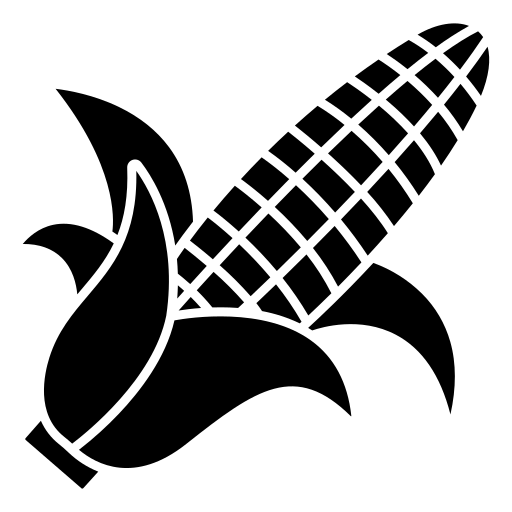
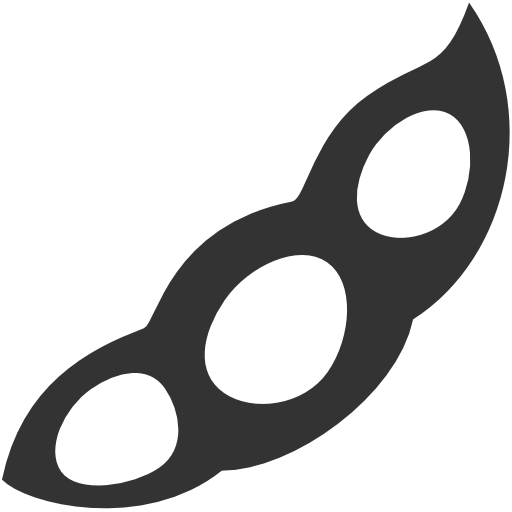

In [23]:
table = (
    GT(res, rowname_col="icon")
    .tab_header(title=f"{gda.year} Harvest",
                subtitle="Progress towards filling contracts"
                )
    .tab_stubhead(label="Crop")
    # .tab_spanner("Earnings", cs.contains("Earnings"))
    .fmt_number(["Contracted", "Delivered", "Harvested", "Total"], decimals=0)    
    # .cols_label(**{
    #     "Total Earnings": "Total $M",
    #     "Off-the-Field Earnings": "Off field $M",
    #     "Off-the-Field Earnings Perc": "Off field %"
    # })
    # .fmt_number(["Total Earnings", "Off-the-Field Earnings"], scale_by = 1/1_000_000, decimals=1)
    .fmt_image("icon", path="./img/")
    .tab_source_note(
        md(
            '<br><div style="text-align: center;">'
            "GNUCash / Meadowland Portal"
            f" | Last Recorded Delivery: {last_delivery.strftime('%Y-%m-%d')}"
            "</div>"
            "<br>"
        )
    )
)
table

In [24]:
path = Path(f"{gda.get_config()["Paths"]["html"]}/contract-progress.html")
path.write_text(table.as_raw_html())

56528

In [25]:
gnuc_prod = gda.get_production().reset_index() \
            .rename(columns={"operation": "Farm",
                             "crop": "Crop",
                             }) \
            .drop(columns=["bu_per_acre", "operation_id"]) \
            .groupby(["Farm", "Crop"]) \
            .sum(numeric_only=True)
gnuc_prod

total_bushels  acres
Farm                 Crop                          
Big Slough           Corn            5379.73 112.10
Gladys's             Corn           10804.46  78.90
                     Soybeans        2102.64  75.40
Home Farm            Soybeans        7779.46 142.80
Les's Lone Tree Farm Corn           24037.76 157.40
                     Soybeans        8460.66 155.30
Lundblad's           Corn           26117.91 147.05
McConnell's          Soybeans        8245.24 152.20

In [16]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

jd_data = pd.read_excel("/home/justin/Downloads/Harvest_2024 (1).xlsx")
jd_data = filter_rows_by_values(jd_data, "Varieties", ["---"])
jd_data = filter_rows_by_values(jd_data, "Moisture", ["---"])
jd_data = filter_rows_by_values(jd_data, "Farms", ["Morin Currie Farms"])
jd_data = jd_data.rename(columns={"Farms": "Farm",
                             "Crop Type": "Crop",
                             }) \
    .groupby(["Farm", "Crop"]) \
    .agg(Harvested=("Area Harvested", "sum"),\
         Dry_Yield=("Total Dry Yield", "sum"), \
         Moisture=("Moisture", "mean"), \
         Date=("Last Harvested", "max")) \
    .reset_index() \
    .set_index(["Farm", "Crop"])
jd_data.head()

Harvested Dry_Yield Moisture  \
Farm                 Crop                                     
Big Slough           Corn          73.18   5379.73     9.84   
Gladys's             Corn          73.56  10860.52    13.30   
                     Soybeans      52.57   2429.63    10.53   
Home Farm            Soybeans     133.95   7980.75    10.02   
Les's Lone Tree Farm Corn         142.45  24037.76    14.89   

                                                 Date  
Farm                 Crop                              
Big Slough           Corn     2024-10-12 17:39:12.029  
Gladys's             Corn     2024-10-10 16:38:11.548  
                     Soybeans 2024-09-25 14:22:45.474  
Home Farm            Soybeans 2024-09-25 14:50:08.221  
Les's Lone Tree Farm Corn     2024-10-08 19:19:00.780

In [17]:
production = jd_data.join(gnuc_prod).fillna(0)
production["New Bushels"] = production["Dry_Yield"] - production["total_bushels"]
production.head(10)

/tmp/ipykernel_483731/679998193.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  production = jd_data.join(gnuc_prod).fillna(0)


Harvested  Dry_Yield  Moisture  \
Farm                 Crop                                       
Big Slough           Corn          73.18    5379.73      9.84   
Gladys's             Corn          73.56   10860.52     13.30   
                     Soybeans      52.57    2429.63     10.53   
Home Farm            Soybeans     133.95    7980.75     10.02   
Les's Lone Tree Farm Corn         142.45   24037.76     14.89   
                     Soybeans     144.80    9038.74     11.36   
Lundblad's           Corn         144.65   26117.91     14.50   
McConnell's          Soybeans     145.16    8630.16     10.17   

                                                 Date  total_bushels  acres  \
Farm                 Crop                                                     
Big Slough           Corn     2024-10-12 17:39:12.029        5379.73 112.10   
Gladys's             Corn     2024-10-10 16:38:11.548       10804.46  78.90   
                     Soybeans 2024-09-25 14:22:45.474        2102.64  75.40   
Home Farm            Soybeans 2024-09-25 14:50:08.221        7779.46 142.80   
Les's Lone Tree Farm Corn     2024-10-08 19:19:00.780       24037.76 157.40   
                     Soybeans 2024-09-25 11:27:46.164        8460.66 155.30   
Lundblad's           Corn     2024-10-11 18:24:22.373       26117.91 147.05   
McConnell's          Soybeans 2024-09-24 17:34:23.921        8245.24 152.20   

                               New Bushels  
Farm                 Crop                   
Big Slough           Corn            -0.00  
Gladys's             Corn            56.06  
                     Soybeans       326.99  
Home Farm            Soybeans       201.29  
Les's Lone Tree Farm Corn            -0.00  
                     Soybeans       578.08  
Lundblad's           Corn             0.00  
McConnell's          Soybeans       384.92

In [18]:
production["Bu/Acres Worked"] = production["total_bushels"] / production["Harvested"]
production["Bu/Total Acres"] = production["total_bushels"] / production["acres"]
production = production.rename(columns={"operation": "Farm",
                                        "acres": "Total Acres",
                                        "total_bushels": "Bushels",
                                        "Harvested": "Acres Worked"}) \
                                .sort_values("Date")
production

,,Acres Worked,Dry_Yield,Moisture,Date,Bushels,Total Acres,New Bushels,Bu/Acres Worked,Bu/Total Acres
Farm,Crop,,,,,,,,,
McConnell's,Soybeans,145.16,8630.16,10.17,2024-09-24 17:34:23.921,8245.24,152.20,384.92,56.80,54.17
Les's Lone Tree Farm,Soybeans,144.80,9038.74,11.36,2024-09-25 11:27:46.164,8460.66,155.30,578.08,58.43,54.48
Gladys's,Soybeans,52.57,2429.63,10.53,2024-09-25 14:22:45.474,2102.64,75.40,326.99,40.00,27.89
Home Farm,Soybeans,133.95,7980.75,10.02,2024-09-25 14:50:08.221,7779.46,142.80,201.29,58.08,54.48
Les's Lone Tree Farm,Corn,142.45,24037.76,14.89,2024-10-08 19:19:00.780,24037.76,157.40,-0.00,168.75,152.72
Gladys's,Corn,73.56,10860.52,13.30,2024-10-10 16:38:11.548,10804.46,78.90,56.06,146.87,136.94
Lundblad's,Corn,144.65,26117.91,14.50,2024-10-11 18:24:22.373,26117.91,147.05,0.00,180.56,177.61
Big Slough,Corn,73.18,5379.73,9.84,2024-10-12 17:39:12.029,5379.73,112.10,-0.00,73.52,47.99


In [19]:
polars_prod = pl.from_pandas(production.reset_index())

prod_res = (
    polars_prod.with_columns(
        (pl.col("Crop").str.to_lowercase() + ".png").alias("icon"),
    )
    .head(9)
    .select("icon", "Farm", "Bushels", "Acres Worked", "Total Acres", "Bu/Acres Worked", "Bu/Total Acres", "Moisture")
)

GT(_tbl_data=shape: (8, 8)
┌─────────────┬─────────────┬──────────┬────────────┬────────┬────────────┬────────────┬───────────┐
│ icon        ┆ Farm        ┆ Bushels  ┆ Acres      ┆ Total  ┆ Bu/Acres   ┆ Bu/Total   ┆ Moisture  │
│ ---         ┆ ---         ┆ ---      ┆ Worked     ┆ Acres  ┆ Worked     ┆ Acres      ┆ ---       │
│ str         ┆ str         ┆ f64      ┆ ---        ┆ ---    ┆ ---        ┆ ---        ┆ f64       │
│             ┆             ┆          ┆ f64        ┆ f64    ┆ f64        ┆ f64        ┆           │
╞═════════════╪═════════════╪══════════╪════════════╪════════╪════════════╪════════════╪═══════════╡
│ soybeans.pn ┆ McConnell's ┆ 8245.24  ┆ 145.16139  ┆ 152.2  ┆ 56.800503  ┆ 54.173719  ┆ 10.172129 │
│ g           ┆             ┆          ┆            ┆        ┆            ┆            ┆           │
│ soybeans.pn ┆ Les's Lone  ┆ 8460.66  ┆ 144.80058  ┆ 155.3  ┆ 58.429739  ┆ 54.479459  ┆ 11.359486 │
│ g           ┆ Tree Farm   ┆          ┆            ┆        ┆            ┆            ┆           │
│ soybeans.pn ┆ Gladys's    ┆ 2102.64  ┆ 52.569053  ┆ 75.4   ┆ 39.997677  ┆ 27.886472  ┆ 10.531652 │
│ g           ┆             ┆          ┆            ┆        ┆            ┆            ┆           │
│ soybeans.pn ┆ Home Farm   ┆ 7779.46  ┆ 133.950872 ┆ 142.8  ┆ 58.076964  ┆ 54.478011  ┆ 10.024808 │
│ g           ┆             ┆          ┆            ┆        ┆            ┆            ┆           │
│ corn.png    ┆ Les's Lone  ┆ 24037.76 ┆ 142.446765 ┆ 157.4  ┆ 168.749076 ┆ 152.717662 ┆ 14.885645 │
│             ┆ Tree Farm   ┆          ┆            ┆        ┆            ┆            ┆           │
│ corn.png    ┆ Gladys's    ┆ 10804.46 ┆ 73.56401   ┆ 78.9   ┆ 146.871548 ┆ 136.938657 ┆ 13.301088 │
│ corn.png    ┆ Lundblad's  ┆ 26117.91 ┆ 144.650431 ┆ 147.05 ┆ 180.558812 ┆ 177.612445 ┆ 14.496786 │
│ corn.png    ┆ Big Slough  ┆ 5379.73  ┆ 73.177171  ┆ 112.1  ┆ 73.516507  ┆ 47.990455  ┆ 9.844731  │
└─────────────┴─────────────┴──────────┴────────────┴────────┴────────────┴────────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x7f2a0b5db320>, _boxhead=Boxhead([ColInfo(var='icon', type=<ColInfoTypeEnum.stub: 2>, column_label='icon', column_align='left', column_width=None), ColInfo(var='Farm', type=<ColInfoTypeEnum.default: 1>, column_label='Farm', column_align='left', column_width=None), ColInfo(var='Bushels', type=<ColInfoTypeEnum.default: 1>, column_label='Bushels', column_align='right', column_width=None), ColInfo(var='Acres Worked', type=<ColInfoTypeEnum.default: 1>, column_label='Acres Worked', column_align='right', column_width=None), ColInfo(var='Total Acres', type=<ColInfoTypeEnum.default: 1>, column_label='Total Acres', column_align='right', column_width=None), ColInfo(var='Bu/Acres Worked', type=<ColInfoTypeEnum.default: 1>, column_label='Bu/Acres Worked', column_align='right', column_width=None), ColInfo(var='Bu/Total Acres', type=<ColInfoTypeEnum.default: 1>, column_label='Bu/Total Acres', column_align='right', column_width=None), ColInfo(var='Moisture', type=<ColInfoTypeEnum.default: 1>, column_label='Moisture', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f2a0b2dad20>, _spanners=Spanners([]), _heading=Heading(title='2024 Production YTD', subtitle='Based on John Deere Operations Center Data', preheader=None), _stubhead='Crop', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f2a103ea150>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f2a0b2db3b0>, <great_tables._gt_data.FormatInfo object at 0x7f2a0b2da960>, <great_tables._gt_data.FormatInfo object at 0x7f2a0b2db9b0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category=
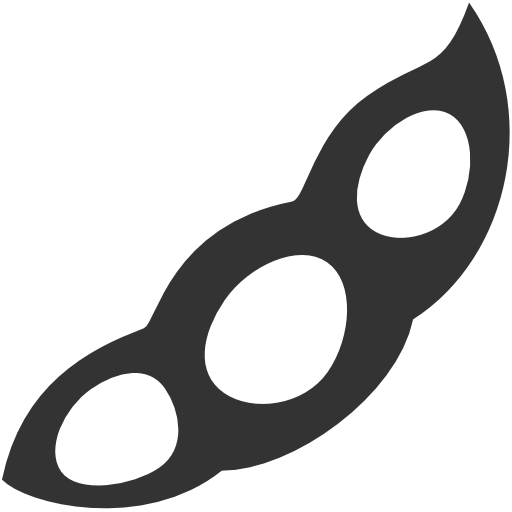
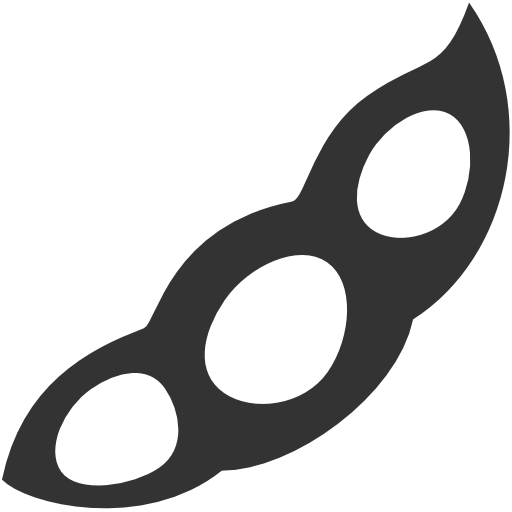
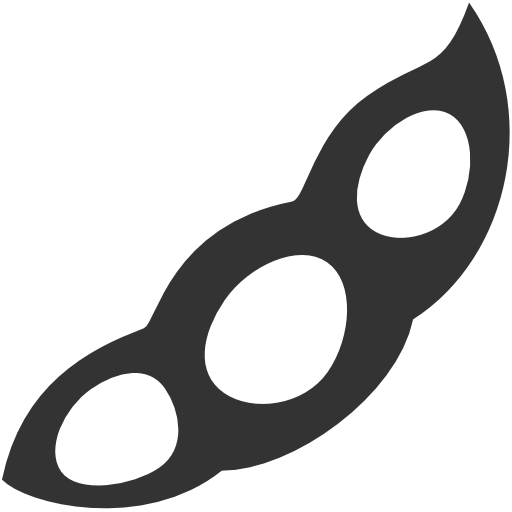
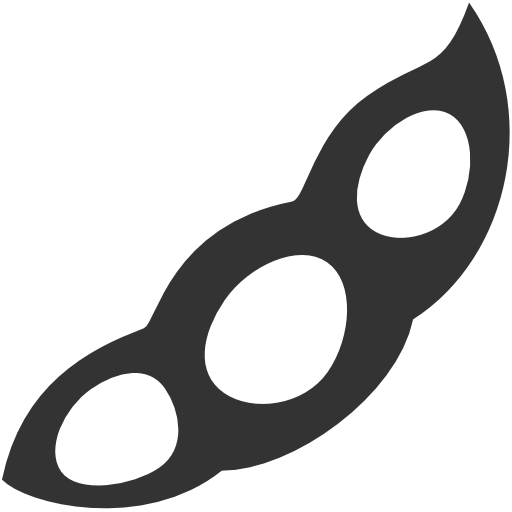
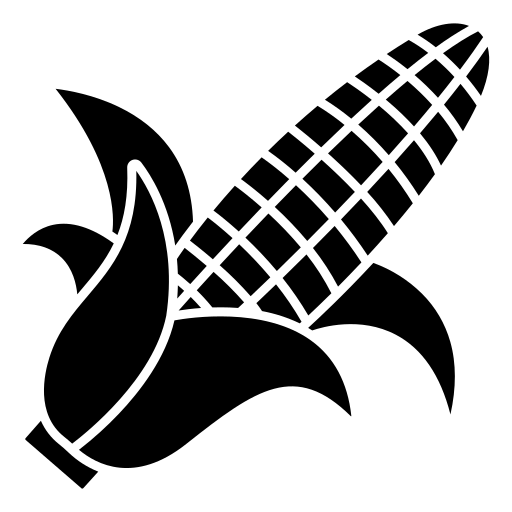
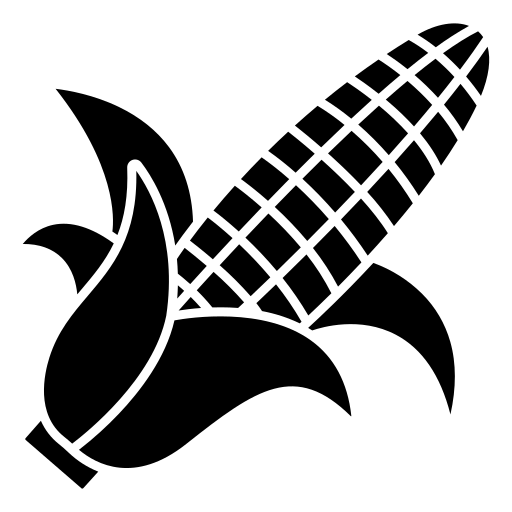
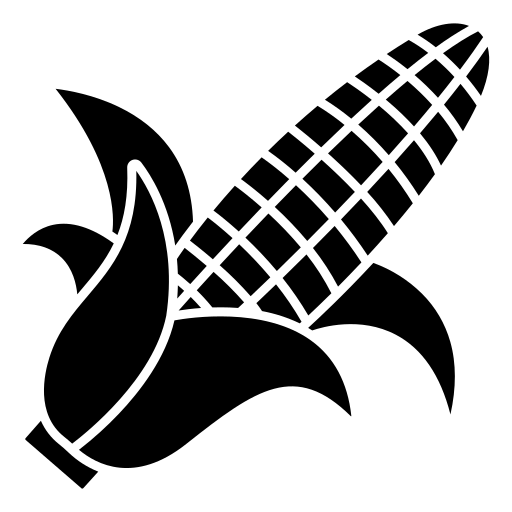
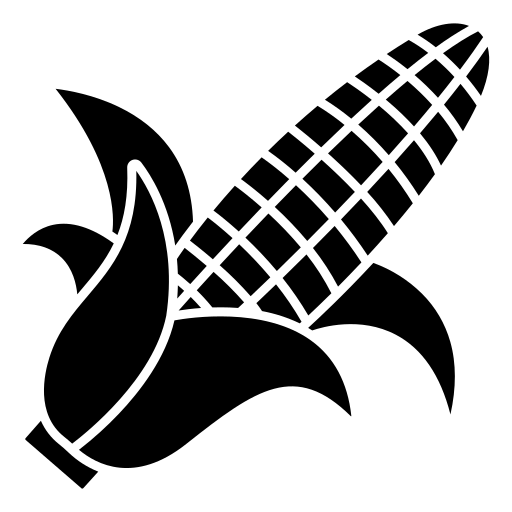

In [26]:
prod_gt = GT(prod_res, rowname_col="icon").tab_header(title=f"{gda.year} Production YTD",
            subtitle="Based on John Deere Operations Center Data") \
               .tab_stubhead(label="Crop") \
               .fmt_number(["Bushels", "Total Acres", "Acres Worked", "Bu/Acres Worked", "Bu/Total Acres"], decimals=0) \
               .fmt_number(["Bu/Acres Worked", "Bu/Total Acres", "Moisture"], decimals=1) \
               .fmt_image("icon", path="./img/")
prod_gt

In [27]:
path = Path(f"{gda.get_config()["Paths"]["html"]}/production.html")
path.write_text(prod_gt.as_raw_html())

201123

'<div id="njzkfjwihf" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">\n<style>\n#njzkfjwihf table {\n          font-family: -apple-system, BlinkMacSystemFont, \'Segoe UI\', Roboto, Oxygen, Ubuntu, Cantarell, \'Helvetica Neue\', \'Fira Sans\', \'Droid Sans\', Arial, sans-serif;\n          -webkit-font-smoothing: antialiased;\n          -moz-osx-font-smoothing: grayscale;\n        }\n\n#njzkfjwihf thead, tbody, tfoot, tr, td, th { border-style: none; }\n tr { background-color: transparent; }\n#njzkfjwihf p { margin: 0; padding: 0; }\n #njzkfjwihf .gt_table { display: table; border-collapse: collapse; line-height: normal; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; borde
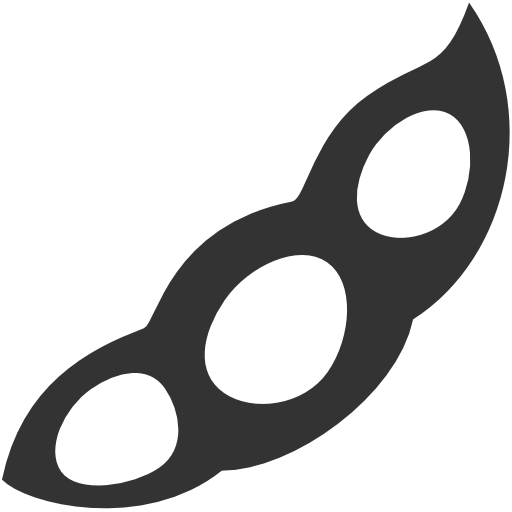
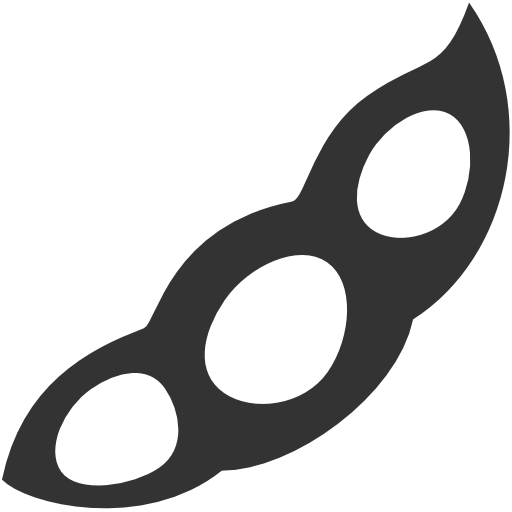
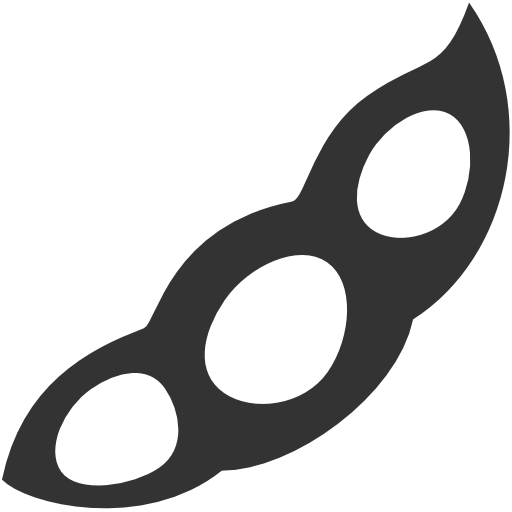
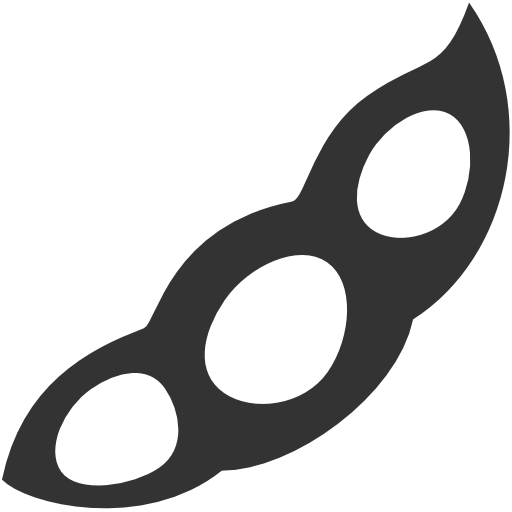
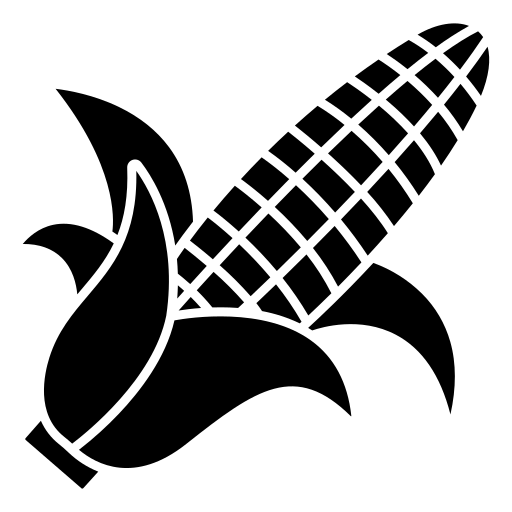
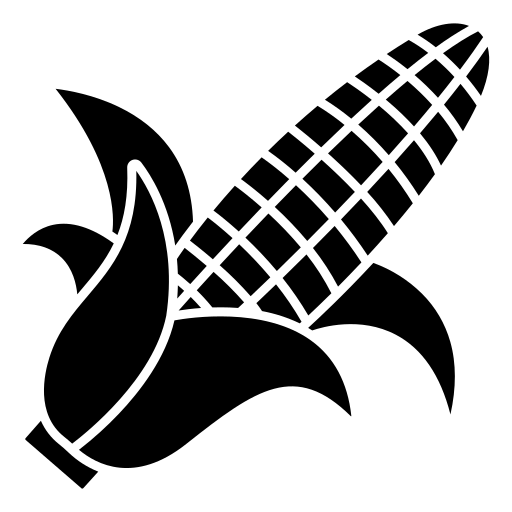
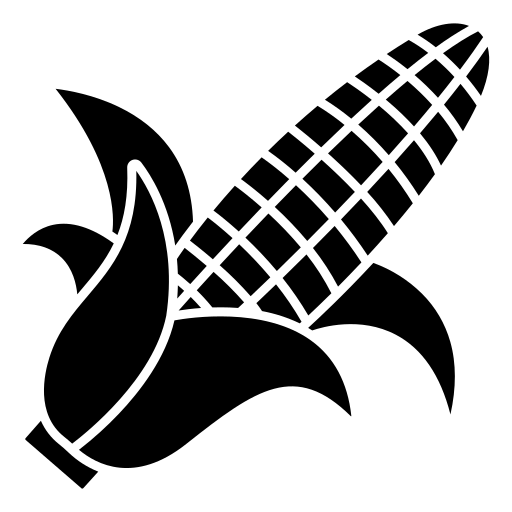
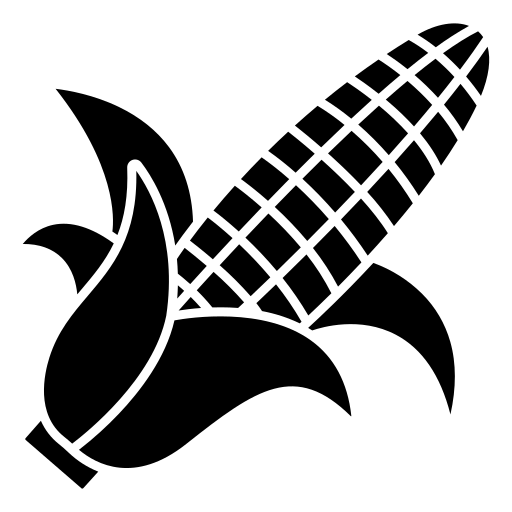

In [28]:
prod_gt.as_raw_html()

In [ ]:
from jinja2 import Environment, FileSystemLoader

file_loader = FileSystemLoader("templates")
env = Environment() # defaults are fine
guts = prod_gt.as_raw_html()
template = env.get_template("printable.html")


output = template.render(
    guts=guts
)